## Overview

This notebook extracts features to use in modeling flood extent for Malawi.

Soil:
- soil type
- soil organic carbon (proxy for soil health and ecosystem condition)
- % clay content of soil (google earth engine)

Water:
- distance to streams
- distance to wetlands

Elevation:
- slope

Climate:
- Climate water deficit 6 months before event (was there a drought that year?)
- total precipitation 6 months weeks before event
- std of precip 6 months before event
- coeficient of variation (standard deviation from the annual mean - would have to get annual mean for 2015 & 2019).

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

In [2]:
# Load Lat/Long points and convert to geodataframe
df = pd.read_csv('data/from_zindi/Train.csv')
pts = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.X, df.Y))
pts.to_file("data/from_zindi/points.shp")

In [3]:
pts.shape

(16466, 41)

## Vector data
- distance to water bodies, wetlands, and streams
- use overaly (union) with geopandas
- Need to project to coordinate system to calculate distances (Arc 1950 / UTM zone 35S is for South Africa (EPSG:20935) units are meters

In [4]:
# Load wetlands data
wetlands = gpd.read_file('data/water/wetlands/wetlands_100.shp')
wetlands.head()

,fid,AREA_METER,PERIMETER_,MW_WETLAND,MW_WETLA_1,MW_WETLA_2,ACRES,HECTARES,geometry
0,1,2029147.125,10289.760,2.0,1.0,2.0,501.411,202.915,"POLYGON ((33.02261 -9.49706, 33.02220 -9.49698..."
1,2,1400282.125,5610.786,4.0,3.0,4.0,346.016,140.028,"POLYGON ((33.14564 -9.49550, 33.14519 -9.49544..."
2,3,1206303.875,8107.262,15.0,14.0,15.0,298.083,120.630,"POLYGON ((33.25196 -9.61700, 33.25134 -9.61693..."
3,4,1576612.500,9315.478,9.0,8.0,9.0,389.588,157.661,"POLYGON ((33.17747 -9.59722, 33.17708 -9.59662..."
4,5,1691864.125,8714.254,14.0,13.0,14.0,418.067,169.186,"POLYGON ((33.06316 -9.62432, 33.06232 -9.62420..."


In [5]:
# Print projection info
wetlands.crs

{'init': 'epsg:4326'}

In [6]:
# Set projection info for pts
pts.crs = 'epsg:4326'

In [7]:
# Re-project pts and wetlands
wetlands = wetlands.to_crs('epsg:20935')
pts_prj = pts.copy()
pts_prj = pts_prj.to_crs('epsg:20935')

/Users/AuerPower/opt/miniconda3/envs/metis/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [8]:
# Calculate distance to wetland for each point (This takes 6 minutes to run)
def min_distance(point, polygon):
    return polygon.distance(point).min()

pts_prj['wetland_dist'] = pts_prj.geometry.apply(min_distance, args=(wetlands, ))

In [9]:
len(pts_prj[pts_prj['wetland_dist'].isna()])

0

In [10]:
# Add to points data frame
pts['wetland_dist'] = pts_prj['wetland_dist']
pts.head()

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,...,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode,Square_ID,geometry,wetland_dist
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.91000),15953.465740
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.90000),16265.216010
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.89000),16645.902409
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.88000),17087.784546
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41,POINT (34.26000 -15.87000),17589.245651


In [11]:
pts.shape

(16466, 42)

## Raster data
- soil carbon
- topographic position index
- Clay content
- use zonalstats from rasterstats

#### Soil organic carbon

In [12]:
# Load the data
soil_carbon_path = os.path.join("data", "soils", "malawi_national_soil_organic_carbon0.tif")

with rio.open(soil_carbon_path) as soil_carbon:
    # Masked = True sets no data values to np.nan if they are in the metadata
    soil_carbon_data = soil_carbon.read(1, masked=True)
    soil_carbon_meta = soil_carbon.profile

In [13]:
soil_carbon_meta

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -1.797693e+308, 'width': 325, 'height': 776, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.01, 0.0, 32.67668701171875,
       0.0, -0.01, -9.364999999999997), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}

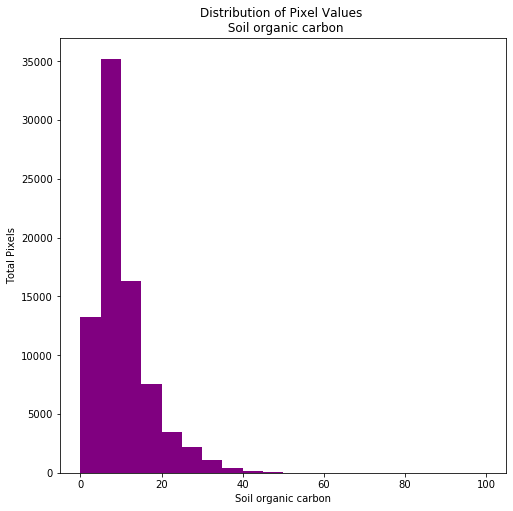

In [14]:
# Plotting a histogram with earthpy
ax=ep.hist(soil_carbon_data,
        figsize=(8,8),
        colors="purple",
        xlabel="Soil organic carbon",
        ylabel="Total Pixels",
        title="Distribution of Pixel Values \n Soil organic carbon")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                     style='plain')

In [15]:
# Extract zonal stats
soil_zs = rs.zonal_stats(pts,
                         soil_carbon_data,
                         nodata=-999,
                         affine=soil_carbon_meta['transform'],
                         geojson_out=True,
                         copy_properties=True,
                         stats='majority')

# View object type
type(soil_zs)

list

In [16]:
# Turn extracted data into a pandas geodataframe
soil_df = gpd.GeoDataFrame.from_features(soil_zs)
soil_df.head(11)

,geometry,LC_Type1_mode,Square_ID,X,Y,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,...,precip 2019-03-31 - 2019-04-07,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,target_2015,wetland_dist,majority
0,POINT (34.26000 -15.91000),9,4e3c3896-14ce-11ea-bce5-f49634744a41,34.26,-15.91,887.764222,0.0,0.0,0.0,14.844025,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15953.465740,4.751131e+00
1,POINT (34.26000 -15.90000),9,4e3c3897-14ce-11ea-bce5-f49634744a41,34.26,-15.90,743.403912,0.0,0.0,0.0,14.844025,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16265.216010,4.977375e+00
2,POINT (34.26000 -15.89000),9,4e3c3898-14ce-11ea-bce5-f49634744a41,34.26,-15.89,565.728343,0.0,0.0,0.0,14.844025,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16645.902409,3.393665e+00
3,POINT (34.26000 -15.88000),10,4e3c3899-14ce-11ea-bce5-f49634744a41,34.26,-15.88,443.392774,0.0,0.0,0.0,14.844025,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17087.784546,3.393665e+00
4,POINT (34.26000 -15.87000),10,4e3c389a-14ce-11ea-bce5-f49634744a41,34.26,-15.87,437.443428,0.0,0.0,0.0,14.844025,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17589.245651,3.167420e+00
5,POINT (34.26000 -15.86000),10,4e3c389b-14ce-11ea-bce5-f49634744a41,34.26,-15.86,405.631747,0.0,0.0,0.0,14.844025,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18145.397965,4.298642e+00
6,POINT (34.26000 -15.85000),10,4e3c389c-14ce-11ea-bce5-f49634744a41,34.26,-15.85,389.261362,0.0,0.0,0.0,14.844025,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18751.375779,3.167420e+00
7,POINT (34.26000 -15.84000),10,4e3c389d-14ce-11ea-bce5-f49634744a41,34.26,-15.84,383.123454,0.0,0.0,0.0,14.844025,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19402.511184,3.167420e+00
8,POINT (34.26000 -15.83000),10,4e3c389e-14ce-11ea-bce5-f49634744a41,34.26,-15.83,382.920492,0.0,0.0,0.0,14.844025,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20094.414795,3.167420e+00
9,POINT (34.27000 -15.92000),9,4e3c389f-14ce-11ea-bce5-f49634744a41,34.27,-15.92,826.058090,0.0,0.0,0.0,14.844025,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14655.331058,-1.797693e+308


In [17]:
# find if there are rows with no data
len(soil_df[soil_df['majority'].isna()])

0

In [18]:
len(soil_df[soil_df['majority'] < 0])

419

In [19]:
# Replace negative values with 0
soil_df['majority'][soil_df['majority'] < 0] = 0

/Users/AuerPower/opt/miniconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
len(soil_df[soil_df['majority'] < 0])

0

In [21]:
soil_df.shape

(16466, 43)

In [22]:
# Join with points dataset
pts['soil_carbon'] = soil_df.majority
pts.shape

(16466, 43)

#### Clay content
This data was extracted using the Google Earth Engine code editor which allows processing on google cloud.

In [23]:
clay10 = gpd.read_file('data/terrain/clay10.shp')
clay200 = gpd.read_file('data/terrain/clay200.shp')
clay10.head()

,X,Y,cly_10_,geometry
0,34.26,-15.91,37.0,POINT (34.26000 -15.91000)
1,34.26,-15.90,29.0,POINT (34.26000 -15.90000)
2,34.26,-15.89,27.0,POINT (34.26000 -15.89000)
3,34.26,-15.88,23.0,POINT (34.26000 -15.88000)
4,34.26,-15.87,23.0,POINT (34.26000 -15.87000)


In [24]:
print(clay10.shape, clay200.shape)

(16466, 4) (16466, 4)


In [25]:
len(clay10[clay10['cly_10_'].isna()])

47

In [26]:
pts['clay_10'] = clay10.cly_10_

In [27]:
pts['clay_200'] = clay200.clay_b200

#### Topographic position Index
This data was extracted using the Google Earth Engine code editor which allows processing on google cloud.

In [28]:
tpi = gpd.read_file('data/terrain/tpi.shp')
tpi.head()

,X,Y,tpi_1km,geometry
0,34.26,-15.91,57.0,POINT (34.26000 -15.91000)
1,34.26,-15.90,112.0,POINT (34.26000 -15.90000)
2,34.26,-15.89,0.0,POINT (34.26000 -15.89000)
3,34.26,-15.88,-4.0,POINT (34.26000 -15.88000)
4,34.26,-15.87,3.0,POINT (34.26000 -15.87000)


In [29]:
tpi.shape

(16466, 4)

In [30]:
pts['TPI'] = tpi.tpi_1km

In [31]:
pts.columns

Index(['X', 'Y', 'target_2015', 'elevation', 'precip 2014-11-16 - 2014-11-23',
       'precip 2014-11-23 - 2014-11-30', 'precip 2014-11-30 - 2014-12-07',
       'precip 2014-12-07 - 2014-12-14', 'precip 2014-12-14 - 2014-12-21',
       'precip 2014-12-21 - 2014-12-28', 'precip 2014-12-28 - 2015-01-04',
       'precip 2015-01-04 - 2015-01-11', 'precip 2015-01-11 - 2015-01-18',
       'precip 2015-01-18 - 2015-01-25', 'precip 2015-01-25 - 2015-02-01',
       'precip 2015-02-01 - 2015-02-08', 'precip 2015-02-08 - 2015-02-15',
       'precip 2015-02-15 - 2015-02-22', 'precip 2015-02-22 - 2015-03-01',
       'precip 2015-03-01 - 2015-03-08', 'precip 2015-03-08 - 2015-03-15',
       'precip 2019-01-20 - 2019-01-27', 'precip 2019-01-27 - 2019-02-03',
       'precip 2019-02-03 - 2019-02-10', 'precip 2019-02-10 - 2019-02-17',
       'precip 2019-02-17 - 2019-02-24', 'precip 2019-02-24 - 2019-03-03',
       'precip 2019-03-03 - 2019-03-10', 'precip 2019-03-10 - 2019-03-17',
       'precip 2019-0

In [32]:
len(clay10[clay10['cly_10_'].isna()])

47

## Transform landcover into dummy variable

In [33]:
landcover = pts.LC_Type1_mode

In [34]:
landcover_dummy = pd.get_dummies(landcover, prefix='landcover')

In [35]:
landcover_dummy.head()

,landcover_2,landcover_4,landcover_5,landcover_7,landcover_8,landcover_9,landcover_10,landcover_11,landcover_12,landcover_13,landcover_14,landcover_17
0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0


In [36]:
# drop landcover column and add dummies
pts = pts.drop(['LC_Type1_mode'], axis=1)
#pts = pts.drop(['landform'], axis=1)
pts.columns

Index(['X', 'Y', 'target_2015', 'elevation', 'precip 2014-11-16 - 2014-11-23',
       'precip 2014-11-23 - 2014-11-30', 'precip 2014-11-30 - 2014-12-07',
       'precip 2014-12-07 - 2014-12-14', 'precip 2014-12-14 - 2014-12-21',
       'precip 2014-12-21 - 2014-12-28', 'precip 2014-12-28 - 2015-01-04',
       'precip 2015-01-04 - 2015-01-11', 'precip 2015-01-11 - 2015-01-18',
       'precip 2015-01-18 - 2015-01-25', 'precip 2015-01-25 - 2015-02-01',
       'precip 2015-02-01 - 2015-02-08', 'precip 2015-02-08 - 2015-02-15',
       'precip 2015-02-15 - 2015-02-22', 'precip 2015-02-22 - 2015-03-01',
       'precip 2015-03-01 - 2015-03-08', 'precip 2015-03-08 - 2015-03-15',
       'precip 2019-01-20 - 2019-01-27', 'precip 2019-01-27 - 2019-02-03',
       'precip 2019-02-03 - 2019-02-10', 'precip 2019-02-10 - 2019-02-17',
       'precip 2019-02-17 - 2019-02-24', 'precip 2019-02-24 - 2019-03-03',
       'precip 2019-03-03 - 2019-03-10', 'precip 2019-03-10 - 2019-03-17',
       'precip 2019-0

In [37]:
pts.shape

(16466, 45)

## Get geographic regions to split data for testing

In [38]:
regions = gpd.read_file('data/human/malawi_district_boundaries/malawi_district_boundaries.shp')
regions.head()

,NO_,DISTRICT,AREA_KM2,geometry
0,25,Balaka,2133.9,"POLYGON ((705206.344 8341597.636, 705196.219 8..."
1,26,Chikwawa,4891.7,"POLYGON ((663262.990 8251321.707, 663312.927 8..."
2,27,Chiradzulu,763.1,"POLYGON ((734595.781 8280124.638, 734642.656 8..."
3,1,Chitipa,4247.7,"POLYGON ((568398.421 8887242.181, 568445.359 8..."
4,12,Dedza,3748.4,"POLYGON ((648323.176 8453798.665, 648344.989 8..."


In [39]:
regions.crs

{'init': 'epsg:32736'}

In [40]:
pts.crs

'epsg:4326'

In [41]:
pts = pts.to_crs('epsg:32736')

In [42]:
pts = gpd.sjoin(pts, regions, op='within') 
pts.head()

/Users/AuerPower/opt/miniconda3/envs/metis/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:32736 != {'init': 'epsg:32736'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,...,geometry,wetland_dist,soil_carbon,clay_10,clay_200,TPI,index_right,NO_,DISTRICT,AREA_KM2
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,POINT (634878.860 8240613.284),15953.465740,4.751131,37.0,40.0,57.0,1,26,Chikwawa,4891.7
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,POINT (634885.529 8241719.647),16265.216010,4.977375,29.0,36.0,112.0,1,26,Chikwawa,4891.7
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,POINT (634892.193 8242826.009),16645.902409,3.393665,27.0,33.0,0.0,1,26,Chikwawa,4891.7
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,POINT (634898.854 8243932.371),17087.784546,3.393665,23.0,29.0,-4.0,1,26,Chikwawa,4891.7
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,POINT (634905.510 8245038.731),17589.245651,3.167420,23.0,30.0,3.0,1,26,Chikwawa,4891.7


In [43]:
pts_df = pd.DataFrame(pts)

In [44]:
pts_df.columns

Index(['X', 'Y', 'target_2015', 'elevation', 'precip 2014-11-16 - 2014-11-23',
       'precip 2014-11-23 - 2014-11-30', 'precip 2014-11-30 - 2014-12-07',
       'precip 2014-12-07 - 2014-12-14', 'precip 2014-12-14 - 2014-12-21',
       'precip 2014-12-21 - 2014-12-28', 'precip 2014-12-28 - 2015-01-04',
       'precip 2015-01-04 - 2015-01-11', 'precip 2015-01-11 - 2015-01-18',
       'precip 2015-01-18 - 2015-01-25', 'precip 2015-01-25 - 2015-02-01',
       'precip 2015-02-01 - 2015-02-08', 'precip 2015-02-08 - 2015-02-15',
       'precip 2015-02-15 - 2015-02-22', 'precip 2015-02-22 - 2015-03-01',
       'precip 2015-03-01 - 2015-03-08', 'precip 2015-03-08 - 2015-03-15',
       'precip 2019-01-20 - 2019-01-27', 'precip 2019-01-27 - 2019-02-03',
       'precip 2019-02-03 - 2019-02-10', 'precip 2019-02-10 - 2019-02-17',
       'precip 2019-02-17 - 2019-02-24', 'precip 2019-02-24 - 2019-03-03',
       'precip 2019-03-03 - 2019-03-10', 'precip 2019-03-10 - 2019-03-17',
       'precip 2019-0

In [45]:
pts_df = pts_df.drop(columns=['geometry', 'index_right', 'NO_', 'AREA_KM2'])

In [46]:
pts_df = pd.concat((pts_df, landcover_dummy), axis=1)
pts_df.head()

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,...,landcover_5,landcover_7,landcover_8,landcover_9,landcover_10,landcover_11,landcover_12,landcover_13,landcover_14,landcover_17
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0,0,0,1,0,0,0,0,0,0
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0,0,0,1,0,0,0,0,0,0
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0,0,0,1,0,0,0,0,0,0
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0,0,0,0,1,0,0,0,0,0
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0,0,0,0,1,0,0,0,0,0


In [47]:
pts_df.shape

(16466, 57)

## Reducing Precip variables

In [48]:
# Separating the train and test sets
# Creating lists of columns to be used in separating the dataframe into training and testing datasets
# Using a for loop for efficiency

precip_features_2019 = []
precip_features_2015 = []
for col in pts_df.columns:
    if '2019' in col:
        precip_features_2019.append(col)
    elif 'precip 2014' in col:
        precip_features_2015.append(col)
    elif 'precip 2015' in col:
        precip_features_2015.append(col)

# Separating the train dataset from the main dataframe
#train = pts_df[pts_df.columns.difference(precip_features_2019)]

In [49]:
# Calculate total precip and standard deviation across weeks
precip_2015 = pts_df[precip_features_2015]
precip_2015.head()

,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,precip 2014-12-28 - 2015-01-04,precip 2015-01-04 - 2015-01-11,precip 2015-01-11 - 2015-01-18,precip 2015-01-18 - 2015-01-25,precip 2015-01-25 - 2015-02-01,precip 2015-02-01 - 2015-02-08,precip 2015-02-08 - 2015-02-15,precip 2015-02-15 - 2015-02-22,precip 2015-02-22 - 2015-03-01,precip 2015-03-01 - 2015-03-08,precip 2015-03-08 - 2015-03-15
0,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0
1,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0
2,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0
3,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0
4,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0


In [50]:
precip_total_2015 = precip_2015.cumsum(axis=1)
precip_total_2015

,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,precip 2014-12-28 - 2015-01-04,precip 2015-01-04 - 2015-01-11,precip 2015-01-11 - 2015-01-18,precip 2015-01-18 - 2015-01-25,precip 2015-01-25 - 2015-02-01,precip 2015-02-01 - 2015-02-08,precip 2015-02-08 - 2015-02-15,precip 2015-02-15 - 2015-02-22,precip 2015-02-22 - 2015-03-01,precip 2015-03-01 - 2015-03-08,precip 2015-03-08 - 2015-03-15
0,0.0,0.0,0.0,14.844025,29.396848,41.634615,99.085975,129.213023,159.66249,161.184319,190.574314,223.452632,231.632436,232.596418,249.255514,252.55998,252.55998
1,0.0,0.0,0.0,14.844025,29.396848,41.634615,99.085975,129.213023,159.66249,161.184319,190.574314,223.452632,231.632436,232.596418,249.255514,252.55998,252.55998
2,0.0,0.0,0.0,14.844025,29.396848,41.634615,99.085975,129.213023,159.66249,161.184319,190.574314,223.452632,231.632436,232.596418,249.255514,252.55998,252.55998
3,0.0,0.0,0.0,14.844025,29.396848,41.634615,99.085975,129.213023,159.66249,161.184319,190.574314,223.452632,231.632436,232.596418,249.255514,252.55998,252.55998
4,0.0,0.0,0.0,14.844025,29.396848,41.634615,99.085975,129.213023,159.66249,161.184319,190.574314,223.452632,231.632436,232.596418,249.255514,252.55998,252.55998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Rain intensity
precip_intensity = pd.DataFrame(index=precip_total_2015.index)

for i in range(1,17):
    column = precip_total_2015.columns[i-1]
    intensity = precip_total_2015[column]/i
    intensity = intensity.to_frame(name='intensity_week' + str(i))
    precip_intensity  = precip_intensity.join(intensity)

precip_intensity.head()

,intensity_week1,intensity_week2,intensity_week3,intensity_week4,intensity_week5,intensity_week6,intensity_week7,intensity_week8,intensity_week9,intensity_week10,intensity_week11,intensity_week12,intensity_week13,intensity_week14,intensity_week15,intensity_week16
0,0.0,0.0,0.0,3.711006,5.87937,6.939102,14.155139,16.151628,17.740277,16.118432,17.324938,18.621053,17.81788,16.61403,16.617034,15.784999
1,0.0,0.0,0.0,3.711006,5.87937,6.939102,14.155139,16.151628,17.740277,16.118432,17.324938,18.621053,17.81788,16.61403,16.617034,15.784999
2,0.0,0.0,0.0,3.711006,5.87937,6.939102,14.155139,16.151628,17.740277,16.118432,17.324938,18.621053,17.81788,16.61403,16.617034,15.784999
3,0.0,0.0,0.0,3.711006,5.87937,6.939102,14.155139,16.151628,17.740277,16.118432,17.324938,18.621053,17.81788,16.61403,16.617034,15.784999
4,0.0,0.0,0.0,3.711006,5.87937,6.939102,14.155139,16.151628,17.740277,16.118432,17.324938,18.621053,17.81788,16.61403,16.617034,15.784999


In [52]:
# Cacluate rain intensity for 2019 precip as well
precip_2019 = pts_df[precip_features_2019]
precip_total_2019 = precip_2019.cumsum(axis=1)

precip_intensity_2019 = pd.DataFrame(index=precip_total_2019.index)

for i in range(1,17):
    column = precip_total_2019.columns[i-1]
    intensity = precip_total_2019[column]/i
    intensity = intensity.to_frame(name='intensity_week' + str(i))
    precip_intensity_2019 = precip_intensity_2019.join(intensity)

precip_intensity_2019.head()

,intensity_week1,intensity_week2,intensity_week3,intensity_week4,intensity_week5,intensity_week6,intensity_week7,intensity_week8,intensity_week9,intensity_week10,intensity_week11,intensity_week12,intensity_week13,intensity_week14,intensity_week15,intensity_week16
0,12.99262,8.787738,17.537669,14.352255,17.098467,14.248722,20.550684,20.264935,19.961885,18.055329,16.566663,15.186108,14.017946,13.016664,12.148886,11.389581
1,12.99262,8.787738,17.537669,14.352255,17.098467,14.248722,20.550684,20.264935,19.961885,18.055329,16.566663,15.186108,14.017946,13.016664,12.148886,11.389581
2,12.99262,8.787738,17.537669,14.352255,17.098467,14.248722,20.550684,20.264935,19.961885,18.055329,16.566663,15.186108,14.017946,13.016664,12.148886,11.389581
3,12.99262,8.787738,17.537669,14.352255,17.098467,14.248722,20.550684,20.264935,19.961885,18.055329,16.566663,15.186108,14.017946,13.016664,12.148886,11.389581
4,12.99262,8.787738,17.537669,14.352255,17.098467,14.248722,20.550684,20.264935,19.961885,18.055329,16.566663,15.186108,14.017946,13.016664,12.148886,11.389581


In [53]:
# Remove weekly precip from training dataframe
train = pts_df[pts_df.columns.difference(precip_features_2019)]
train = train.drop(columns=list(precip_features_2015))

In [54]:
# Attach intensity to training dataframe
train = train.join(precip_intensity)

In [55]:
# Save data
train.to_csv('data/final_train_data/train.csv', index=False)

train_geo = gpd.GeoDataFrame(train, geometry = gpd.points_from_xy(df.X, df.Y))
train_geo.to_file("data/from_zindi/points_train.shp")

In [56]:
# Save train version with weekly precip to see if it makes a difference
train2 = pts_df[pts_df.columns.difference(precip_features_2019)]
train2.to_csv('data/final_train_data/train_weekly_precip.csv', index=False)

In [57]:
# Save train with cumsum version instead of intensity
train3 = pts_df[pts_df.columns.difference(precip_features_2019)]
train3 = train3.drop(columns=list(precip_features_2015))

train3 = train3.join(precip_total_2015)
train3.to_csv('data/final_train_data/train_cumsum_precip.csv', index=False)

## 2019 Test dataset

In [58]:
# Precip variables for 2019 test data
test = pts_df[pts_df.columns.difference(precip_features_2015)]
test = test.drop(columns=list(precip_features_2019))
test = test.join(precip_intensity)

In [59]:
# 2019 test data
flood_2019 = gpd.read_file('data/from_zindi/target_flood_2019.shp')
flood_2019.head()

,X,Y,layer,geometry
0,34.26,-15.91,0.0,POINT (634878.860 8240613.284)
1,34.26,-15.90,0.0,POINT (634885.529 8241719.647)
2,34.26,-15.89,0.0,POINT (634892.193 8242826.009)
3,34.26,-15.88,0.0,POINT (634898.854 8243932.371)
4,34.26,-15.87,0.0,POINT (634905.510 8245038.731)


In [60]:
flood_2019 = pd.DataFrame(flood_2019.drop(columns='geometry'))
test = pd.concat([test, flood_2019['layer']], axis=1)

In [61]:
test.columns

Index(['DISTRICT', 'Square_ID', 'TPI', 'X', 'Y', 'clay_10', 'clay_200',
       'elevation', 'landcover_10', 'landcover_11', 'landcover_12',
       'landcover_13', 'landcover_14', 'landcover_17', 'landcover_2',
       'landcover_4', 'landcover_5', 'landcover_7', 'landcover_8',
       'landcover_9', 'soil_carbon', 'target_2015', 'wetland_dist',
       'intensity_week1', 'intensity_week2', 'intensity_week3',
       'intensity_week4', 'intensity_week5', 'intensity_week6',
       'intensity_week7', 'intensity_week8', 'intensity_week9',
       'intensity_week10', 'intensity_week11', 'intensity_week12',
       'intensity_week13', 'intensity_week14', 'intensity_week15',
       'intensity_week16', 'layer'],
      dtype='object')

In [62]:
# Save test data frame
test = test.rename(columns={'layer': 'target_2019'})
test = test.drop(['target_2015'], axis=1)
test.to_csv('data/final_train_data/test_2019.csv', index=False)

In [65]:
# Save geo dataframe for mapping
test_geo = gpd.GeoDataFrame(test, geometry = gpd.points_from_xy(df.X, df.Y))
test_geo.to_file("data/final_train_data/test_2019.shp")

In [ ]:
# Save test data frame for total precipitation 